In [1]:
## Introduction
from matplotlib import pyplot as plt
import numpy as np
from metpy.units import units

from metpy.plots import SkewT

/home/roberto/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/quantity.py:1238: RuntimeWarning: divide by zero encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


26.558981793525447 kilometer


/home/roberto/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/quantity.py:1238: RuntimeWarning: invalid value encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Tropopause Altitude:  404.30295340678157 millibar


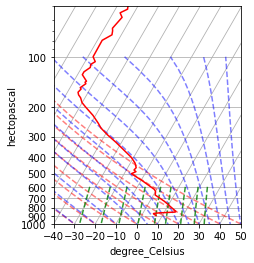

In [2]:
from testTropCalc import grabSounding

In [3]:
year = 2020
month = 3
day = 23
hour = 12
station = "AMA"

134 133
hectopascal


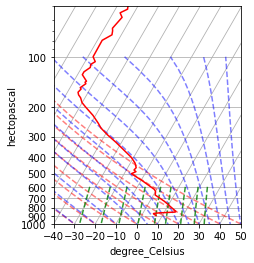

In [4]:
pFull, TFull = grabSounding(year, month, day, hour, station)
nLev = pFull.size
nLevm = nLev-1
print(nLev, nLevm)
print(pFull.units)
skew = SkewT()
skew.plot(pFull, TFull, 'r')
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_ylim(1000, 50)

plt.show()

In [5]:
## # INPUTS

# nLev -- Total number of points in sounding data
# nLevm -- (nLev-1) Total number of "middle" points

# pFull -- (nLev x 1) Full pressure array from sounding
# TFull -- (nLev x 1) Full temperature array from sounding
# lapseC -- Lapse rate threshold (default to 2K/km)

# lapse -- (nLevm x 1) array of calculated lapse rates
# pHalf -- (nLevm x 1) array of average pressure between pFull elements

# OUTPUTS
# pTrop -- Calculated height of trop
iTrop = -999 # Index of layer containing trop height in sounding arrays
lapseC = 2.0

In [6]:
# Variables defined within the scope of our function

pMin = 85.0*pFull.units # (mb or hPa) Lowest pressure to assign trop
pMax = 450.0*pFull.units # (mb or hPa) Highest pressure to assign trop
# p1 -- Used when linearly interpolating in log(p) to find trop height
# p2 -- Used when linearly interpolating in log(p) to find trop height
# weight -- Used when linearly interpolating in log(p) to find trop height

dZ = 2.0 # (km) Height at which to check average lapse rate above trop
# p2km -- Pressure 2 km above trop (for use in calculating average lapse rate a height dZ above pTrop)
# lapseAvg -- Used when calculating the average lapse rate
# lapseSum -- Used when calculating the average lapse rate
# kount -- Used when calculating the average lapse rate
# L -- Used to iterate when calculating the average lapse rate, we won't use this since we're using numpy functions to work with arrays?

# iLev -- Used to iterate through pFull and TFull, we probably won't use this since we're using numpy functions to work with arrays?
# iLev1 -- iLev + 1

grav = 9.80665 # Gravity (m/s-2)
R = 287.0 # Ideal gas constant (J/K)
const = 1000.0*grav/R # constant for use in hypsometric equation; factor of 1000 to convert from m to km

found = False # Keep track of whether we've found trop height

In [7]:
#155 - 165
#loop from model top to surface and calculate lapse rate 
# gamma = -dT/dz (K/km)
lapse = np.zeros(nLevm)
pHalf = np.zeros(nLevm)*pFull.units
for iLev in range(0, nLevm): #need information here for loop...
    lapse[iLev] = np.log(TFull[iLev]/TFull[iLev+1])
    lapse[iLev] = lapse[iLev]/(np.log(pFull[iLev]/pFull[iLev+1]))
    
    lapse[iLev]=const*lapse[iLev]
    pHalf[iLev]=(pFull[iLev]+pFull[iLev+1])*0.5
print(lapse)
print(lapse.size)

[ 10.87128151   8.20197106  -5.31961138 -42.11500446 -93.21044366
 -91.60898187 -20.16386327  -2.79150649  -2.27239934   7.19698599
   7.19925695   6.9361358    7.39780586   9.57194729   8.72221291
   8.79561532   1.84652852   2.29091802   5.11347408   8.59052244
   8.78849659   8.36252555   8.99923292   9.73437489   9.75729085
   0.          -7.79883215  -8.152563     8.2281445    7.04124365
  -1.66059024   3.82901593   5.67538796   0.           6.53999205
   7.52568142   7.79021885   8.52524427   8.66758116   8.62380911
   7.93374472   5.92423487   6.66044139   7.98743561   7.74076341
   7.5566948    4.99097709   4.85233294   7.21134041   4.60632203
   0.          -2.23961342   6.75337681  -4.96905737  -4.81905808
   6.24854147  -4.6092532    6.98817146   0.          -5.27880106
  -4.99573224   1.58587768   2.45311464  -6.28611303   5.859709
   0.14652633  -6.98954416   2.67425287   2.34711828   3.82126029
   3.56187158  -1.82576118  -1.68742242   5.80059359   5.84601029
  -7.4801908

/home/roberto/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/numpy_func.py:295: RuntimeWarning: divide by zero encountered in true_divide
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/home/roberto/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/numpy_func.py:295: RuntimeWarning: invalid value encountered in true_divide
  result_magnitude = func(*stripped_args, **stripped_kwargs)


In [8]:
#166-183
#loop from surface to top to find lowest tropopause
for iLev in range(0,nLevm-1): #need informatinformation here for loop
    if (lapse[iLev] < lapseC) & (pFull[iLev] < pMax):
        if (not found):
            P1 = np.log(pHalf[iLev].magnitude)
            P2 = np.log(pHalf[iLev+1].magnitude)
            if (lapse[iLev] != lapse[iLev+1]):
                weight = (lapseC-lapse[iLev])/(lapse[iLev+1]-lapse[iLev])
                
                #tropopause pressure
                pTrop = np.exp(P1+weight*(P2-P1))
            else:
                pTrop = pHalf[iLev].magnitude
                
            p2km = np.exp(np.log(pTrop)-dZ*const/TFull[iLev].magnitude)

            lapseAvg = 0 
            lapseSum = 0 
            kount = 0 
            for L in range (iLev,nLevm):
                if pHalf[L].magnitude > p2km:
                    lapseAvg = lapseSum + lapse[L]
                    kount = kount + 1
                    lapseAvg = lapseSum/kount
            found = lapseAvg < lapseC
            if not found:
                print ("Tropopause not found")
            else:
                pTrop=np.max([pTrop,pMin.magnitude])
                print ("Tropopause Altitude: ", pTrop)

Tropopause Altitude:  404.30311428014625


Loop 3 (187- 199)
Check for average lapse rate 2km above tropopause and check if it is less than the threshold (Can also be done using numpy stuff I think)